In [2]:
import pandas as pd
import re
import requests

# Función para parsear el símbolo de opción
def parse_option_symbol(symbol):
    """
    Parsea un símbolo de opción argentina
    Formato: XXXC/V[precio][mes]
    Ejemplo: ALUC400.OC -> ALU (ticker), C (call), 400 (strike), OC (octubre)
    """
    # Patrones para opciones
    # Puede ser XXXC/V[número].[mes] o XXXC/V[número][mes]
    
    # Intentar extraer el ticker (primeras 3-4 letras)
    match = re.match(r'^([A-Z]+)([CV])(\d+(?:\.\d+)?)[.\-]?([A-Z]{2})?$', symbol)
    
    if match:
        ticker = match.group(1)
        option_type = 'Call' if match.group(2) == 'C' else 'Put'
        strike = float(match.group(3))
        month_code = match.group(4) if match.group(4) else ''
        
        return {
            'underlying_ticker': ticker,
            'option_type': option_type,
            'strike': strike,
            'month_code': month_code,
            'full_symbol': symbol
        }
    return None

# Diccionario de meses
month_codes = {
    'EN': 'Enero',
    'FB': 'Febrero', 
    'MR': 'Marzo',
    'AB': 'Abril',
    'MY': 'Mayo',
    'JN': 'Junio',
    'JL': 'Julio',
    'AG': 'Agosto',
    'ST': 'Septiembre',
    'OC': 'Octubre',
    'NV': 'Noviembre',
    'DI': 'Diciembre',
    'FE': 'Febrero'  # Variante
}

# URLs
url_options = 'https://data912.com/live/arg_options'
url_stocks = 'https://data912.com/live/arg_stocks'

# Obtener datos
print("Obteniendo datos...")
options_data = requests.get(url_options).json()
stocks_data = requests.get(url_stocks).json()

# Crear DataFrames
df_options = pd.DataFrame(options_data)
df_stocks = pd.DataFrame(stocks_data)

# Parsear símbolos de opciones
print("\nParseando símbolos de opciones...")
parsed_options = []

for idx, row in df_options.iterrows():
    parsed = parse_option_symbol(row['symbol'])
    if parsed:
        parsed.update({
            'px_bid': row['px_bid'],
            'px_ask': row['px_ask'],
            'volume': row['v'],
            'last_price': row['c'],
            'pct_change': row['pct_change']
        })
        parsed_options.append(parsed)

df_options_parsed = pd.DataFrame(parsed_options)

# Crear mapeo entre tickers de opciones y acciones
print("\nCreando mapeo de equivalencias...")

# MAPEO MANUAL DE EXCEPCIONES - Agregar aquí casos especiales
manual_mapping = {
    'GFG': 'GGAL',     # Galicia: opciones GFG -> acción GGAL
    'YPF': 'YPFD',     # YPF: opciones YPF -> acción YPFD
    # Agregar más casos especiales aquí si los encuentras
}

# Los tickers pueden tener algunas variaciones, vamos a crear un mapeo
ticker_mapping = {}

for option_ticker in df_options_parsed['underlying_ticker'].unique():
    # Primero verificar si existe en el mapeo manual
    if option_ticker in manual_mapping:
        ticker_mapping[option_ticker] = manual_mapping[option_ticker]
        print(f"Mapeo manual: {option_ticker} -> {manual_mapping[option_ticker]}")
    # Buscar coincidencia exacta
    elif option_ticker in df_stocks['symbol'].values:
        ticker_mapping[option_ticker] = option_ticker
    else:
        # Buscar coincidencia parcial
        matches = df_stocks[df_stocks['symbol'].str.startswith(option_ticker[:3])]
        if not matches.empty:
            ticker_mapping[option_ticker] = matches.iloc[0]['symbol']

# Merge de datos
df_merged = df_options_parsed.merge(
    df_stocks[['symbol', 'c', 'px_bid', 'px_ask']].rename(columns={
        'symbol': 'stock_symbol',
        'c': 'stock_price',
        'px_bid': 'stock_bid',
        'px_ask': 'stock_ask'
    }),
    left_on=df_options_parsed['underlying_ticker'].map(ticker_mapping),
    right_on='stock_symbol',
    how='left'
)

# Agregar mes en texto
df_merged['month'] = df_merged['month_code'].map(month_codes)

# Calcular métricas importantes
df_merged['moneyness'] = df_merged.apply(
    lambda x: 'ITM' if (x['option_type'] == 'Call' and x['stock_price'] > x['strike']) or 
                       (x['option_type'] == 'Put' and x['stock_price'] < x['strike'])
              else 'ATM' if abs(x['stock_price'] - x['strike']) / x['stock_price'] < 0.05
              else 'OTM',
    axis=1
)

df_merged['intrinsic_value'] = df_merged.apply(
    lambda x: max(0, x['stock_price'] - x['strike']) if x['option_type'] == 'Call'
              else max(0, x['strike'] - x['stock_price']),
    axis=1
)

# Mostrar resultados
print("\n" + "="*80)
print("EQUIVALENCIAS OPCIONES - ACCIONES")
print("="*80)

print("\nMapeo de tickers:")
for opt_ticker, stock_ticker in ticker_mapping.items():
    print(f"{opt_ticker} -> {stock_ticker}")

print(f"\n\nTotal de opciones: {len(df_merged)}")
print(f"Acciones subyacentes únicas: {df_merged['stock_symbol'].nunique()}")

# Verificar que GGAL y YPFD estén presentes
print(f"\nOpciones de GGAL encontradas: {len(df_merged[df_merged['stock_symbol']=='GGAL'])}")
print(f"Opciones de YPFD encontradas: {len(df_merged[df_merged['stock_symbol']=='YPFD'])}")

print("\n\nMuestra de datos con precios de acciones subyacentes:")
display_cols = ['full_symbol', 'underlying_ticker', 'stock_symbol', 'stock_price', 
                'option_type', 'strike', 'last_price', 'moneyness', 'intrinsic_value', 'month']

print(df_merged[display_cols].head(20).to_string())

# Resumen por acción
print("\n\nRESUMEN POR ACCIÓN SUBYACENTE:")
print("="*80)

summary = df_merged.groupby('stock_symbol').agg({
    'full_symbol': 'count',
    'stock_price': 'first',
    'option_type': lambda x: f"Calls: {sum(x=='Call')}, Puts: {sum(x=='Put')}"
}).rename(columns={'full_symbol': 'num_options'})

print(summary.to_string())

# Guardar DataFrames para uso posterior
print("\n\nDataFrames guardados:")
print("- df_options: Opciones originales")
print("- df_stocks: Acciones originales")
print("- df_options_parsed: Opciones parseadas")
print("- df_merged: Opciones con datos de acciones subyacentes")

Obteniendo datos...

Parseando símbolos de opciones...

Creando mapeo de equivalencias...
Mapeo manual: GFG -> GGAL

EQUIVALENCIAS OPCIONES - ACCIONES

Mapeo de tickers:
ALU -> ALUA
BBA -> BBAR
BHI -> BHIP
BMA -> BMA
BYM -> BYMA
CEC -> CECO2
CEP -> CEPU
COM -> COME
CRE -> CRE3W
EDN -> EDN
GFG -> GGAL
LOM -> LOMA
MET -> METR
PAM -> PAMP
SUP -> SUPV
TEC -> TECO2
TGN -> TGN4D
TGS -> TGSU2
TRA -> TRAN
TXA -> TXAR


Total de opciones: 415
Acciones subyacentes únicas: 20

Opciones de GGAL encontradas: 17
Opciones de YPFD encontradas: 0


Muestra de datos con precios de acciones subyacentes:
   full_symbol underlying_ticker stock_symbol  stock_price option_type  strike  last_price moneyness  intrinsic_value      month
0   ALUC1050OC               ALU         ALUA        653.0        Call  1050.0       2.760       OTM              0.0    Octubre
1   ALUC400.DI               ALU         ALUA        653.0        Call   400.0     303.290       ITM            253.0  Diciembre
2   ALUC400.OC       

In [3]:
df_merged

,underlying_ticker,option_type,strike,month_code,full_symbol,px_bid,px_ask,volume,last_price,pct_change,stock_symbol,stock_price,stock_bid,stock_ask,month,moneyness,intrinsic_value
0,ALU,Call,1050.0,OC,ALUC1050OC,0.000,34.999,0.0,2.760,0.00,ALUA,653.0,603.0,700.0,Octubre,OTM,0.0
1,ALU,Call,400.0,DI,ALUC400.DI,305.000,329.998,276.0,303.290,-2.63,ALUA,653.0,603.0,700.0,Diciembre,ITM,253.0
2,ALU,Call,400.0,OC,ALUC400.OC,250.000,270.000,590.0,270.000,-1.81,ALUA,653.0,603.0,700.0,Octubre,ITM,253.0
3,ALU,Call,500.0,DI,ALUC500.DI,200.001,222.000,5.0,215.001,-4.74,ALUA,653.0,603.0,700.0,Diciembre,ITM,153.0
4,ALU,Call,600.0,DI,ALUC600.DI,78.001,0.000,0.0,0.000,0.00,ALUA,653.0,603.0,700.0,Diciembre,ITM,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,TXA,Put,550.0,OC,TXAV550.OC,14.200,0.000,0.0,0.000,0.00,TXAR,550.0,520.0,617.0,Octubre,ATM,0.0
411,TXA,Put,600.0,DI,TXAV600.DI,64.000,75.000,0.0,80.200,0.00,TXAR,550.0,520.0,617.0,Diciembre,ITM,50.0
412,TXA,Put,600.0,OC,TXAV600.OC,12.000,0.000,0.0,8.000,0.00,TXAR,550.0,520.0,617.0,Octubre,ITM,50.0
413,TXA,Put,650.0,DI,TXAV650.DI,71.600,0.000,0.0,0.000,0.00,TXAR,550.0,520.0,617.0,Diciembre,ITM,100.0


Buscando oportunidades de STRADDLE y STRANGLE...

Encontradas 95 oportunidades de estrategias:

MEJORES ESTRATEGIAS (por menor costo):
    type stock  stock_price  call_strike  put_strike  total_cost  pct_to_breakeven_up  pct_to_breakeven_down  min_move_pct
Strangle  COME        29.49         35.0        34.0       2.290            26.449644               7.527976      7.527976
Strangle  COME        29.49         35.0        31.0       2.450            26.992201              -3.187521      3.187521
Straddle  COME        29.49         31.0        31.0       3.000            15.293320              -5.052560      5.052560
Strangle  COME        29.49         33.0        31.0       3.790            24.754154              -7.731434      7.731434
Straddle  COME        29.49         31.0        31.0       5.534            23.886063             -13.645303     13.645303
Strangle  COME        29.49         34.0        32.0       5.636            34.404883             -10.600203     10.600203
Stra

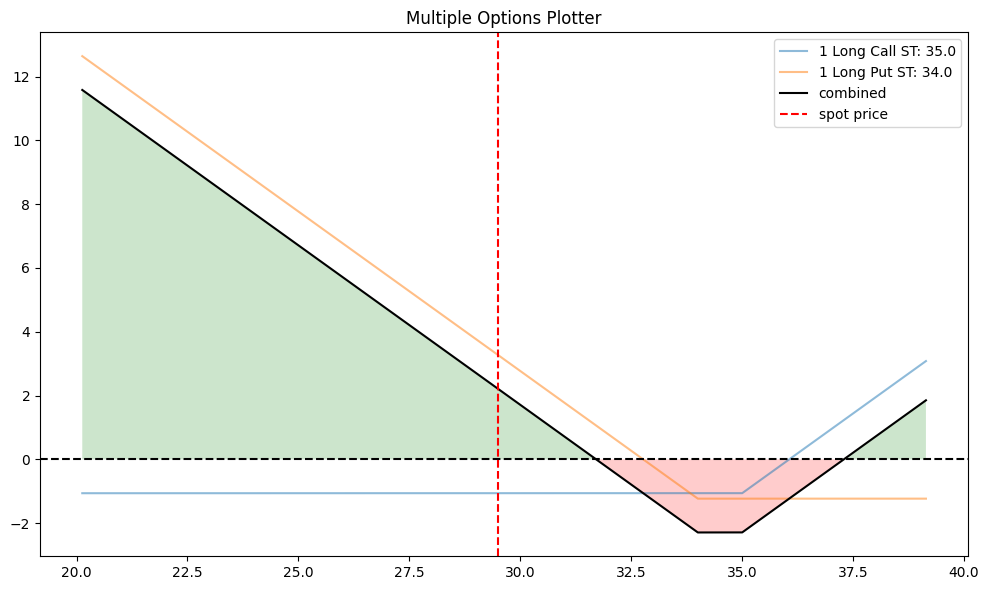



ANÁLISIS DE SENSIBILIDAD:
Cambio % Precio Valor Call Valor Put    P&L   P&L %
    -20% $23.59      $0.00    $10.41  $8.12 +354.5%
    -15% $25.07      $0.00     $8.93  $6.64 +290.1%
    -10% $26.54      $0.00     $7.46  $5.17 +225.7%
     -5% $28.02      $0.00     $5.98  $3.69 +161.3%
     +0% $29.49      $0.00     $4.51  $2.22  +96.9%
     +5% $30.96      $0.00     $3.04  $0.75  +32.6%
    +10% $32.44      $0.00     $1.56 $-0.73  -31.8%
    +15% $33.91      $0.00     $0.09 $-2.20  -96.2%
    +20% $35.39      $0.39     $0.00 $-1.90  -83.1%


✅ Se creó 'df_strategies' con 95 estrategias encontradas


💡 TIPS:
- Ver todas las estrategias: df_strategies
- Ver columnas disponibles: df_strategies.columns
- Filtrar por tipo: df_strategies[df_strategies['type']=='Straddle']
- Ordenar por movimiento: df_strategies.sort_values('min_move_pct')
- Analizar estrategia: analyze_strategy('TICKER', CALL_STRIKE, PUT_STRIKE, 'MES')


In [5]:
import opstrat as op
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Filtrar opciones del mismo subyacente y mismo vencimiento para straddle/strangle
print("Buscando oportunidades de STRADDLE y STRANGLE...")
print("="*80)

# Agrupar por subyacente y mes
strategy_opportunities = []

for stock_symbol in df_merged['stock_symbol'].unique():
    if pd.isna(stock_symbol):
        continue
    
    for month in df_merged['month_code'].unique():
        if pd.isna(month):
            continue
        
        # Filtrar opciones del mismo subyacente y mes
        subset = df_merged[
            (df_merged['stock_symbol'] == stock_symbol) & 
            (df_merged['month_code'] == month)
        ]
        
        if len(subset) < 2:
            continue
        
        stock_price = subset['stock_price'].iloc[0]
        
        # Obtener todas las calls y puts disponibles
        calls = subset[subset['option_type'] == 'Call'].copy()
        puts = subset[subset['option_type'] == 'Put'].copy()
        
        if calls.empty or puts.empty:
            continue
        
        # ESTRATEGIA 1: Buscar straddles exactos (mismo strike)
        common_strikes = set(calls['strike']) & set(puts['strike'])
        
        for strike in common_strikes:
            call = calls[calls['strike'] == strike].iloc[0]
            put = puts[puts['strike'] == strike].iloc[0]
            
            if call['last_price'] > 0 and put['last_price'] > 0:
                total_cost = call['last_price'] + put['last_price']
                
                strategy_opportunities.append({
                    'type': 'Straddle',
                    'stock': stock_symbol,
                    'stock_price': stock_price,
                    'call_strike': strike,
                    'put_strike': strike,
                    'month': month,
                    'month_text': subset.iloc[0]['month'],
                    'call_price': call['last_price'],
                    'put_price': put['last_price'],
                    'total_cost': total_cost,
                    'call_symbol': call['full_symbol'],
                    'put_symbol': put['full_symbol'],
                    'breakeven_up': strike + total_cost,
                    'breakeven_down': strike - total_cost,
                    'distance_to_atm': abs(strike - stock_price) / stock_price * 100
                })
        
        # ESTRATEGIA 2: Buscar strangles (strikes diferentes)
        for _, call in calls.iterrows():
            for _, put in puts.iterrows():
                if call['strike'] >= put['strike'] and call['last_price'] > 0 and put['last_price'] > 0:
                    if call['strike'] == put['strike']:
                        continue
                    
                    total_cost = call['last_price'] + put['last_price']
                    breakeven_up = call['strike'] + total_cost
                    breakeven_down = put['strike'] - total_cost
                    
                    strike_diff = (call['strike'] - put['strike']) / stock_price * 100
                    if strike_diff <= 20:
                        strategy_opportunities.append({
                            'type': 'Strangle',
                            'stock': stock_symbol,
                            'stock_price': stock_price,
                            'call_strike': call['strike'],
                            'put_strike': put['strike'],
                            'month': month,
                            'month_text': subset.iloc[0]['month'],
                            'call_price': call['last_price'],
                            'put_price': put['last_price'],
                            'total_cost': total_cost,
                            'call_symbol': call['full_symbol'],
                            'put_symbol': put['full_symbol'],
                            'breakeven_up': breakeven_up,
                            'breakeven_down': breakeven_down,
                            'distance_to_atm': min(abs(call['strike'] - stock_price), abs(put['strike'] - stock_price)) / stock_price * 100
                        })

df_strategies = pd.DataFrame(strategy_opportunities)

if not df_strategies.empty:
    # Agregar columnas de porcentaje de movimiento necesario
    df_strategies['pct_to_breakeven_up'] = ((df_strategies['breakeven_up'] / df_strategies['stock_price']) - 1) * 100
    df_strategies['pct_to_breakeven_down'] = ((df_strategies['breakeven_down'] / df_strategies['stock_price']) - 1) * 100
    
    # Agregar columna del movimiento mínimo necesario (el menor de los dos en valor absoluto)
    df_strategies['min_move_pct'] = df_strategies.apply(
        lambda x: min(abs(x['pct_to_breakeven_up']), abs(x['pct_to_breakeven_down'])), 
        axis=1
    )
    
    print(f"\nEncontradas {len(df_strategies)} oportunidades de estrategias:\n")
    
    # Ordenar por menor costo total
    df_strategies = df_strategies.sort_values('total_cost')
    
    # Mostrar estrategias con columnas de porcentaje
    print("MEJORES ESTRATEGIAS (por menor costo):")
    print("="*120)
    
    display_cols = ['type', 'stock', 'stock_price', 'call_strike', 'put_strike', 'total_cost',
                    'pct_to_breakeven_up', 'pct_to_breakeven_down', 'min_move_pct']
    
    print(df_strategies[display_cols].head(15).to_string(index=False))
    
    # También ordenar por movimiento mínimo necesario
    print("\n\nESTRATEGIAS ORDENADAS POR MOVIMIENTO MÍNIMO NECESARIO:")
    print("="*120)
    
    df_by_min_move = df_strategies.sort_values('min_move_pct')
    print(df_by_min_move[display_cols].head(15).to_string(index=False))
    
    # Resumen y estadísticas
    print(f"\n\nRESUMEN:")
    print(f"Total estrategias: {len(df_strategies)}")
    print(f"- Straddles: {len(df_strategies[df_strategies['type']=='Straddle'])}")
    print(f"- Strangles: {len(df_strategies[df_strategies['type']=='Strangle'])}")
    
    print(f"\n\nESTADÍSTICAS GENERALES:")
    print(f"Costo promedio: ${df_strategies['total_cost'].mean():.2f}")
    print(f"Movimiento promedio necesario: {df_strategies['min_move_pct'].mean():.2f}%")
    print(f"Movimiento mínimo necesario (mejor caso): {df_strategies['min_move_pct'].min():.2f}%")
    print(f"Movimiento máximo necesario (peor caso): {df_strategies['min_move_pct'].max():.2f}%")
    
    # Análisis por tipo de estrategia
    print(f"\n\nANÁLISIS POR TIPO DE ESTRATEGIA:")
    for strategy_type in ['Straddle', 'Strangle']:
        subset = df_strategies[df_strategies['type'] == strategy_type]
        if not subset.empty:
            print(f"\n{strategy_type}:")
            print(f"  - Cantidad: {len(subset)}")
            print(f"  - Costo promedio: ${subset['total_cost'].mean():.2f}")
            print(f"  - Movimiento promedio necesario: {subset['min_move_pct'].mean():.2f}%")
            print(f"  - Mejor oportunidad (menor movimiento): {subset['min_move_pct'].min():.2f}%")
    
    # Graficar la mejor oportunidad
    print("\n\nGRAFICANDO LA MEJOR OPORTUNIDAD (menor costo):")
    print("="*80)
    
    best_strategy = df_strategies.iloc[0]
    
    print(f"\nTipo: {best_strategy['type']}")
    print(f"Stock: {best_strategy['stock']}")
    print(f"Precio actual: ${best_strategy['stock_price']:.2f}")
    print(f"Strike Call: ${best_strategy['call_strike']:.2f}")
    print(f"Strike Put: ${best_strategy['put_strike']:.2f}")
    print(f"Vencimiento: {best_strategy['month_text']}")
    print(f"Call ({best_strategy['call_symbol']}): ${best_strategy['call_price']:.2f}")
    print(f"Put ({best_strategy['put_symbol']}): ${best_strategy['put_price']:.2f}")
    print(f"Costo total: ${best_strategy['total_cost']:.2f}")
    print(f"Breakeven superior: ${best_strategy['breakeven_up']:.2f} ({best_strategy['pct_to_breakeven_up']:+.1f}%)")
    print(f"Breakeven inferior: ${best_strategy['breakeven_down']:.2f} ({best_strategy['pct_to_breakeven_down']:+.1f}%)")
    print(f"Movimiento mínimo necesario: {best_strategy['min_move_pct']:.1f}%")
    
    op_call = {
        'op_type': 'c',
        'strike': best_strategy['call_strike'],
        'tr_type': 'b',
        'op_pr': best_strategy['call_price']
    }
    
    op_put = {
        'op_type': 'p',
        'strike': best_strategy['put_strike'],
        'tr_type': 'b',
        'op_pr': best_strategy['put_price']
    }
    
    plt.close('all')
    
    # Calcular el rango dinámico basado en los breakevens
    min_price = min(best_strategy['breakeven_down'], best_strategy['stock_price'])
    max_price = max(best_strategy['breakeven_up'], best_strategy['stock_price'])
    
    price_range = max_price - min_price
    margin = price_range * 0.2
    
    lower_bound = min_price - margin
    upper_bound = max_price + margin
    
    range_percentage = max(
        abs((upper_bound - best_strategy['stock_price']) / best_strategy['stock_price'] * 100),
        abs((best_strategy['stock_price'] - lower_bound) / best_strategy['stock_price'] * 100)
    )
    
    op.multi_plotter(
        spot=best_strategy['stock_price'],
        spot_range=range_percentage,
        op_list=[op_call, op_put]
    )
    
    figs = plt.get_fignums()
    
    for fig_num in figs:
        fig = plt.figure(fig_num)
        ax = fig.gca()
        
        ax.set_title(f"{best_strategy['type']} - {best_strategy['stock']}\n"
                    f"Call ${best_strategy['call_strike']:.0f} + Put ${best_strategy['put_strike']:.0f} | "
                    f"Costo: ${best_strategy['total_cost']:.2f}\n"
                    f"Necesita {best_strategy['pct_to_breakeven_up']:+.1f}% (↑) o {best_strategy['pct_to_breakeven_down']:+.1f}% (↓)", 
                     fontsize=14, fontweight='bold', pad=20)
        
        fig.set_size_inches(16, 9)
        fig.tight_layout()
    
    plt.show()
    
    # Análisis de sensibilidad
    print("\n\nANÁLISIS DE SENSIBILIDAD:")
    print("="*80)
    
    price_changes = [-20, -15, -10, -5, 0, 5, 10, 15, 20]
    sensitivity_data = []
    
    for pct_change in price_changes:
        future_price = best_strategy['stock_price'] * (1 + pct_change/100)
        
        call_value = max(0, future_price - best_strategy['call_strike'])
        put_value = max(0, best_strategy['put_strike'] - future_price)
        total_value = call_value + put_value
        pnl = total_value - best_strategy['total_cost']
        pnl_pct = (pnl / best_strategy['total_cost']) * 100 if best_strategy['total_cost'] > 0 else 0
        
        sensitivity_data.append({
            'Cambio %': f"{pct_change:+.0f}%",
            'Precio': f"${future_price:.2f}",
            'Valor Call': f"${call_value:.2f}",
            'Valor Put': f"${put_value:.2f}",
            'P&L': f"${pnl:.2f}",
            'P&L %': f"{pnl_pct:+.1f}%"
        })
    
    df_sensitivity = pd.DataFrame(sensitivity_data)
    print(df_sensitivity.to_string(index=False))
    
    print(f"\n\n✅ Se creó 'df_strategies' con {len(df_strategies)} estrategias encontradas")
    
else:
    print("\nNo se encontraron oportunidades de estrategias en los datos actuales.")

# Función para analizar una estrategia específica
def analyze_strategy(stock_symbol, call_strike, put_strike, month_code):
    """
    Analiza una estrategia específica (straddle o strangle)
    """
    subset = df_merged[
        (df_merged['stock_symbol'] == stock_symbol) & 
        (df_merged['month_code'] == month_code)
    ]
    
    call_option = subset[(subset['option_type'] == 'Call') & (subset['strike'] == call_strike)]
    put_option = subset[(subset['option_type'] == 'Put') & (subset['strike'] == put_strike)]
    
    if not call_option.empty and not put_option.empty:
        stock_price = call_option.iloc[0]['stock_price']
        call_price = call_option.iloc[0]['last_price']
        put_price = put_option.iloc[0]['last_price']
        total_cost = call_price + put_price
        
        strategy_type = 'Straddle' if call_strike == put_strike else 'Strangle'
        
        breakeven_up = call_strike + total_cost
        breakeven_down = put_strike - total_cost
        
        pct_up = ((breakeven_up / stock_price) - 1) * 100
        pct_down = ((breakeven_down / stock_price) - 1) * 100
        
        op_call = {'op_type': 'c', 'strike': call_strike, 'tr_type': 'b', 'op_pr': call_price}
        op_put = {'op_type': 'p', 'strike': put_strike, 'tr_type': 'b', 'op_pr': put_price}
        
        plt.close('all')
        
        # Calcular rango dinámico
        min_price = min(breakeven_down, stock_price)
        max_price = max(breakeven_up, stock_price)
        price_range = max_price - min_price
        margin = price_range * 0.2
        
        lower_bound = min_price - margin
        upper_bound = max_price + margin
        
        range_percentage = max(
            abs((upper_bound - stock_price) / stock_price * 100),
            abs((stock_price - lower_bound) / stock_price * 100)
        )
        
        op.multi_plotter(spot=stock_price, spot_range=range_percentage, op_list=[op_call, op_put])
        
        figs = plt.get_fignums()
        for fig_num in figs:
            fig = plt.figure(fig_num)
            ax = fig.gca()
            ax.set_title(f"{strategy_type} - {stock_symbol} ({month_code})\n"
                        f"Call ${call_strike} + Put ${put_strike} | Costo: ${total_cost:.2f}\n"
                        f"Necesita {pct_up:+.1f}% (↑) o {pct_down:+.1f}% (↓)", 
                        fontsize=14, fontweight='bold', pad=20)
            fig.set_size_inches(16, 9)
            fig.tight_layout()
        
        plt.show()
        
        print(f"\n{strategy_type} Analysis:")
        print(f"Precio actual: ${stock_price:.2f}")
        print(f"Costo total: ${total_cost:.2f}")
        print(f"Breakeven superior: ${breakeven_up:.2f} ({pct_up:+.1f}%)")
        print(f"Breakeven inferior: ${breakeven_down:.2f} ({pct_down:+.1f}%)")
        print(f"Movimiento mínimo necesario: {min(abs(pct_up), abs(pct_down)):.1f}%")
    else:
        print(f"No se encontró la estrategia completa")

print("\n\n💡 TIPS:")
print("- Ver todas las estrategias: df_strategies")
print("- Ver columnas disponibles: df_strategies.columns")
print("- Filtrar por tipo: df_strategies[df_strategies['type']=='Straddle']")
print("- Ordenar por movimiento: df_strategies.sort_values('min_move_pct')")
print("- Analizar estrategia: analyze_strategy('TICKER', CALL_STRIKE, PUT_STRIKE, 'MES')")

In [6]:
df_strategies

,type,stock,stock_price,call_strike,put_strike,month,month_text,call_price,put_price,total_cost,call_symbol,put_symbol,breakeven_up,breakeven_down,distance_to_atm,pct_to_breakeven_up,pct_to_breakeven_down,min_move_pct
22,Strangle,COME,29.49,35.0,34.0,OC,Octubre,1.060,1.23,2.290,COMC35.0OC,COMV34.0OC,37.290,31.710,15.293320,26.449644,7.527976,7.527976
21,Strangle,COME,29.49,35.0,31.0,OC,Octubre,1.060,1.39,2.450,COMC35.0OC,COMV31.0OC,37.450,28.550,5.120380,26.992201,-3.187521,3.187521
19,Straddle,COME,29.49,31.0,31.0,OC,Octubre,1.610,1.39,3.000,COMC31.0OC,COMV31.0OC,34.000,28.000,5.120380,15.293320,-5.052560,5.052560
20,Strangle,COME,29.49,33.0,31.0,OC,Octubre,2.400,1.39,3.790,COMC33.0OC,COMV31.0OC,36.790,27.210,5.120380,24.754154,-7.731434,7.731434
23,Straddle,COME,29.49,31.0,31.0,DI,Diciembre,4.334,1.20,5.534,COMC31.0DI,COMV31.0DI,36.534,25.466,5.120380,23.886063,-13.645303,13.645303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,Straddle,GGAL,4100.00,4500.0,4500.0,DI,Diciembre,630.000,610.00,1240.000,GFGC4500DI,GFGV4500DI,5740.000,3260.000,9.756098,40.000000,-20.487805,20.487805
64,Strangle,PAMP,3572.50,3000.0,2400.0,DI,Diciembre,1399.000,24.00,1423.000,PAMC3000DI,PAMV2400DI,4423.000,977.000,16.025192,23.806858,-72.652204,23.806858
65,Strangle,PAMP,3572.50,3000.0,2820.0,DI,Diciembre,1399.000,139.00,1538.000,PAMC3000DI,PAMV2820DI,4538.000,1282.000,16.025192,27.025892,-64.114766,27.025892
83,Strangle,TGSU2,6420.00,7300.0,6100.0,DI,Diciembre,1580.700,153.40,1734.100,TGSC7300DI,TGSV6100DI,9034.100,4365.900,4.984424,40.718069,-31.995327,31.995327
